In [28]:
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo
from sklearn.datasets import load_iris, load_wine
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

### Wczytywanie zbiorów

In [2]:
iris_dataset = load_iris(as_frame=True).frame

In [3]:
wine = load_wine(as_frame=True).frame

In [29]:
polish_companies_bankruptcy = fetch_ucirepo(id=365)
features = polish_companies_bankruptcy.data.features
target = polish_companies_bankruptcy.data.targets
companies = pd.concat([features, target], axis=1)

### Czyszczenie zbiorów

In [5]:
print("Null Value Counts in Iris Dataset:")
print("---------------------------------")
for column, count in iris_dataset.isnull().sum().items():
    print(f"{column:15} : {count}")


Null Value Counts in Iris Dataset:
---------------------------------
sepal length (cm) : 0
sepal width (cm) : 0
petal length (cm) : 0
petal width (cm) : 0
target          : 0


In [6]:
 iris_dataset.duplicated().sum()

np.int64(1)

In [7]:
iris_dataset = iris_dataset.drop_duplicates()

In [8]:
print("Null Value Counts in Wine Dataset:")
print("---------------------------------")
for column, count in wine.isnull().sum().items():
    print(f"{column:15} : {count}")


Null Value Counts in Wine Dataset:
---------------------------------
alcohol         : 0
malic_acid      : 0
ash             : 0
alcalinity_of_ash : 0
magnesium       : 0
total_phenols   : 0
flavanoids      : 0
nonflavanoid_phenols : 0
proanthocyanins : 0
color_intensity : 0
hue             : 0
od280/od315_of_diluted_wines : 0
proline         : 0
target          : 0


In [9]:
 wine.duplicated().sum()

np.int64(0)

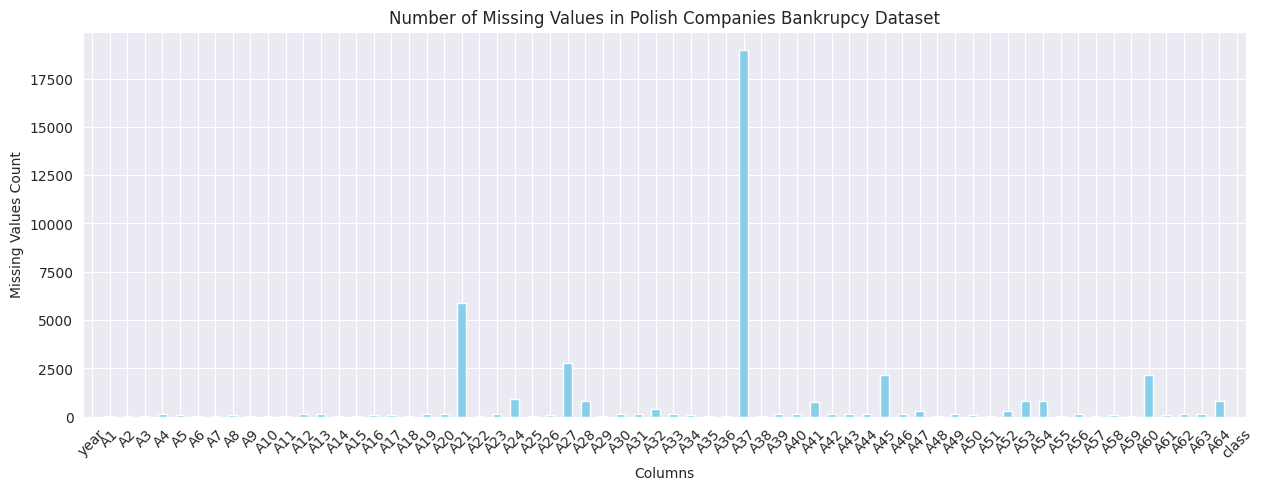

In [10]:
null_counts = companies.isnull().sum()
plt.figure(figsize=(15, 5))
null_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Missing Values in Polish Companies Bankrupcy Dataset')
plt.xlabel('Columns')
plt.ylabel('Missing Values Count')
plt.xticks(rotation=45)
plt.show()

In [30]:
def fill_missing(df, class_column):
    for column in df.columns:
        if column == class_column:
            continue
        mode_by_class = df.groupby(class_column)[column].apply(lambda x: x.mode()[0])
        df[column] = df.apply(
            lambda row: mode_by_class[row[class_column]] if pd.isna(row[column]) else row[column],
            axis=1
        )
    return df

In [31]:
companies = fill_missing(companies, 'class')

In [32]:
companies = companies.drop_duplicates()

In [15]:
def clip_outliers_column_by_class(df, column, class_column, class1, class2):
    df_copy = df.copy(deep=True)
    class1_data = df_copy[df_copy[class_column] == class1]
    class2_data = df_copy[df_copy[class_column] == class2]

    q1_1 = class1_data[column].quantile(0.25)
    q3_1 = class1_data[column].quantile(0.75)
    iqr_1 = q3_1 - q1_1
    lower_bound_1 = q1_1 - 1.5 * iqr_1
    upper_bound_1 = q3_1 + 1.5 * iqr_1

    q1_2 = class2_data[column].quantile(0.25)
    q3_2 = class2_data[column].quantile(0.75)
    iqr_2 = q3_2 - q1_2
    lower_bound_2 = q1_2 - 1.5 * iqr_2
    upper_bound_2 = q3_2 + 1.5 * iqr_2

    mask_class1 = (df_copy[class_column] == class1)
    df_copy.loc[mask_class1 & (df_copy[column] < lower_bound_1), column] = lower_bound_1
    df_copy.loc[mask_class1 & (df_copy[column] > upper_bound_1), column] = upper_bound_1

    mask_class2 = (df_copy[class_column] == class2)
    df_copy.loc[mask_class2 & (df_copy[column] < lower_bound_2), column] = lower_bound_2
    df_copy.loc[mask_class2 & (df_copy[column] > upper_bound_2), column] = upper_bound_2

    return df_copy

def clip_outliers_by_class(df, columns, class_column, class1, class2):
    data = df.copy(deep=True)
    for col in columns:
        print(f"\nProcessing column: {col}")
        print(f"Initial shape: {data.shape}")
        print(f"Initial variance by class:")
        print(f"{class1}: {data[data[class_column] == class1][col].var()}")
        print(f"{class2}: {data[data[class_column] == class2][col].var()}")

        data = clip_outliers_column_by_class(data, col, class_column, class1, class2)

        print(f"\nAfter clipping outliers:")
        print(f"Shape remains: {data.shape}")
        print(f"New variance by class:")
        print(f"{class1}: {data[data[class_column] == class1][col].var()}")
        print(f"{class2}: {data[data[class_column] == class2][col].var()}")

    return data

In [16]:
variance = companies.var("rows")[:-1]
variance_sorted = variance.sort_values(ascending=False)

In [17]:
companies = clip_outliers_by_class(companies, variance_sorted[:11].index, "class", 0, 1)
companies = companies.drop(columns=list(variance_sorted[-2:].index))


Processing column: A43
Initial shape: (43004, 66)
Initial variance by class:
0: 22921398687.77835
1: 2835077.529654233

After clipping outliers:
Shape remains: (43004, 66)
New variance by class:
0: 3516.429237883316
1: 5393.359156419952

Processing column: A62
Initial shape: (43004, 66)
Initial variance by class:
0: 20484018446.216526
1: 742739356.3190928

After clipping outliers:
Shape remains: (43004, 66)
New variance by class:
0: 3472.275372617306
1: 10761.549332815266

Processing column: A44
Initial shape: (43004, 66)
Initial variance by class:
0: 12808503666.271961
1: 1978942.011653955

After clipping outliers:
Shape remains: (43004, 66)
New variance by class:
0: 1345.7864403837493
1: 1827.2260965101846

Processing column: A15
Initial shape: (43004, 66)
Initial variance by class:
0: 9669980862.321634
1: 3266223125.4156075

After clipping outliers:
Shape remains: (43004, 66)
New variance by class:
0: 4013338.7437230176
1: 23282846.341199808

Processing column: A32
Initial shape: (

### Podział na zbiory treningowy / testowy

In [33]:
test = 0.8
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(*(iris_dataset.iloc[:, :-1], iris_dataset.iloc[:, -1]), test_size=test, stratify=iris_dataset.iloc[:, -1])
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(*(wine.iloc[:, :-1], wine.iloc[:, -1]), test_size=test, stratify=wine.iloc[:, -1])
X_train_companies, X_test_companies, y_train_companies, y_test_companies = train_test_split(*(companies.iloc[:, :-1], companies.iloc[:, -1]), test_size=test, stratify=companies.iloc[:, -1])

### Standaryzacja danych

In [34]:
scaler = StandardScaler()
X_train_iris_scaled = scaler.fit_transform(X_train_iris)
X_test_iris_scaled = scaler.transform(X_test_iris)
X_train_wine_scaled = scaler.fit_transform(X_train_wine)
X_test_wine_scaled = scaler.transform(X_test_wine)
X_train_companies_scaled = scaler.fit_transform(X_train_companies)
X_test_companies_scaled = scaler.transform(X_test_companies)

### PCA

In [35]:
pca = PCA(n_components=0.95)
X_train_iris_pca = pca.fit_transform(X_train_iris_scaled)
X_test_iris_pca = pca.transform(X_test_iris_scaled)
X_train_wine_pca = pca.fit_transform(X_train_wine_scaled)
X_test_wine_pca = pca.transform(X_test_wine_scaled)
X_train_companies_pca = pca.fit_transform(X_train_companies_scaled)
X_test_companies_pca = pca.transform(X_test_companies_scaled)

### K-nn dla zbioru IRIS dla domyślnych parametrów

In [22]:
model = KNeighborsClassifier()
model.fit(X_train_iris_scaled, y_train_iris)

KNeighborsClassifier()


Test results:

Accuracy: 0.9166666666666666

Classification Report for IRIS dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.81      0.97      0.89        40
           2       0.97      0.78      0.86        40

    accuracy                           0.92       120
   macro avg       0.93      0.92      0.92       120
weighted avg       0.93      0.92      0.92       120



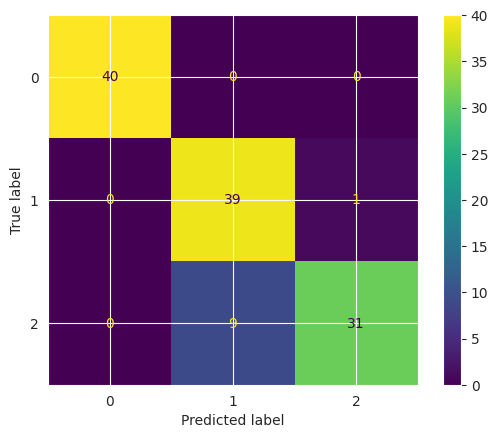

In [23]:
predictions = model.predict(X_test_iris_scaled)
result = accuracy_score(y_test_iris, predictions)
print("\nTest results:")
print("\nAccuracy:", result)
print("\nClassification Report for IRIS dataset:")
print(classification_report(y_test_iris, predictions))

cm = confusion_matrix(y_test_iris, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

### K-nn dla zbioru WINE dla domyślnych parametrów

In [24]:
model = KNeighborsClassifier()
model.fit(X_train_wine_scaled, y_train_wine)

KNeighborsClassifier()


Test results:

Accuracy: 0.9440559440559441

Classification Report for WINE dataset:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        47
           1       1.00      0.86      0.92        57
           2       0.97      1.00      0.99        39

    accuracy                           0.94       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.94      0.94       143



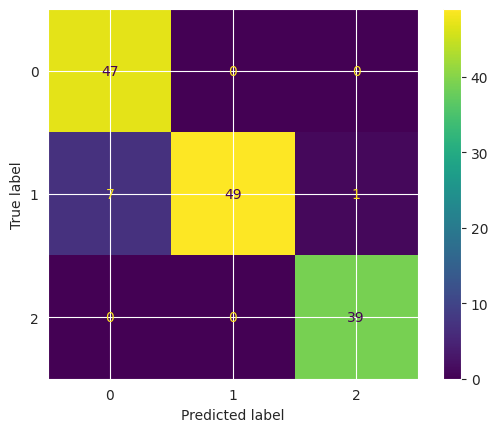

In [25]:
predictions = model.predict(X_test_wine_scaled)
result = accuracy_score(y_test_wine, predictions)
print("\nTest results:")
print("\nAccuracy:", result)
print("\nClassification Report for WINE dataset:")
print(classification_report(y_test_wine, predictions))

cm = confusion_matrix(y_test_wine, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

### K-nn dla zbioru Companies dla domyślnych parametrów

In [26]:
model = KNeighborsClassifier()
model.fit(X_train_companies_pca, y_train_companies)

KNeighborsClassifier()


Test results:

Accuracy: 0.9772991512614813

Classification Report for Companies dataset:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     32738
           1       1.00      0.53      0.69      1666

    accuracy                           0.98     34404
   macro avg       0.99      0.77      0.84     34404
weighted avg       0.98      0.98      0.97     34404



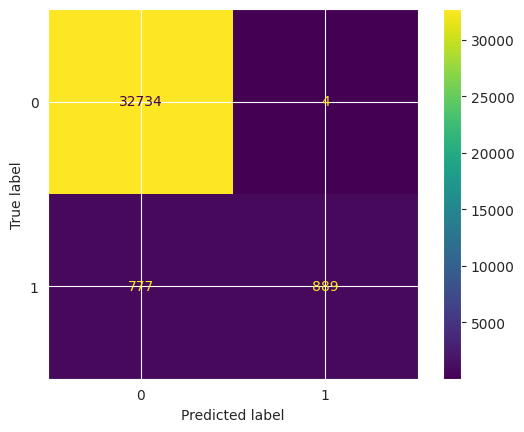

In [27]:
predictions = model.predict(X_test_companies_pca)
result = accuracy_score(y_test_companies, predictions)
print("\nTest results:")
print("\nAccuracy:", result)
print("\nClassification Report for Companies dataset:")
print(classification_report(y_test_companies, predictions))

cm = confusion_matrix(y_test_companies, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()


Test results:

Accuracy: 0.9499476805022672

Classification Report for Companies dataset:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     32738
           1       0.35      0.04      0.07      1666

    accuracy                           0.95     34404
   macro avg       0.65      0.52      0.52     34404
weighted avg       0.92      0.95      0.93     34404



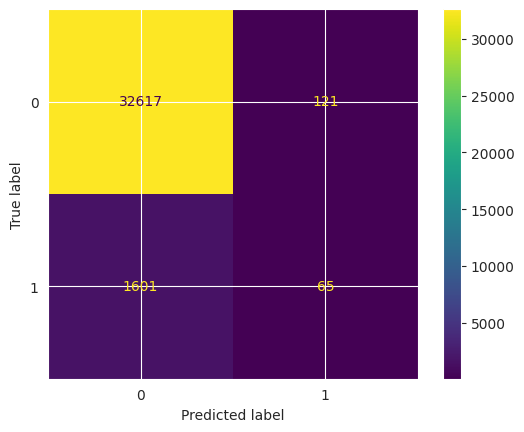

In [36]:

model = KNeighborsClassifier()
model.fit(X_train_companies_pca, y_train_companies)
predictions = model.predict(X_test_companies_pca)
result = accuracy_score(y_test_companies, predictions)
print("\nTest results:")
print("\nAccuracy:", result)
print("\nClassification Report for Companies dataset:")
print(classification_report(y_test_companies, predictions))

cm = confusion_matrix(y_test_companies, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# Analiza skuteczności algorytmu K-nn na zbiorze IRIS dla różnych parametrów
## Zmiana liczby foldów w walidacji krzyżowej

Korzystamy z klasy Pipeline aby nie doprowadzić do przecieku danych podczas walidacji krzyżowej.

In [371]:
model = KNeighborsClassifier()
preprocessor =  Pipeline(
                    [
                        ("scaler", StandardScaler()),
                    ])
pipeline = make_pipeline(preprocessor, model)
folds = [2, 5, 10]

In [376]:
scores = []
for fold in folds:
    cv = KFold(n_splits=fold, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_iris, y_train_iris, cv=cv, scoring="f1_macro")
    scores.append(f1_scores)

Text(0.5, 1.0, 'F1-Score for Different Fold Counts')

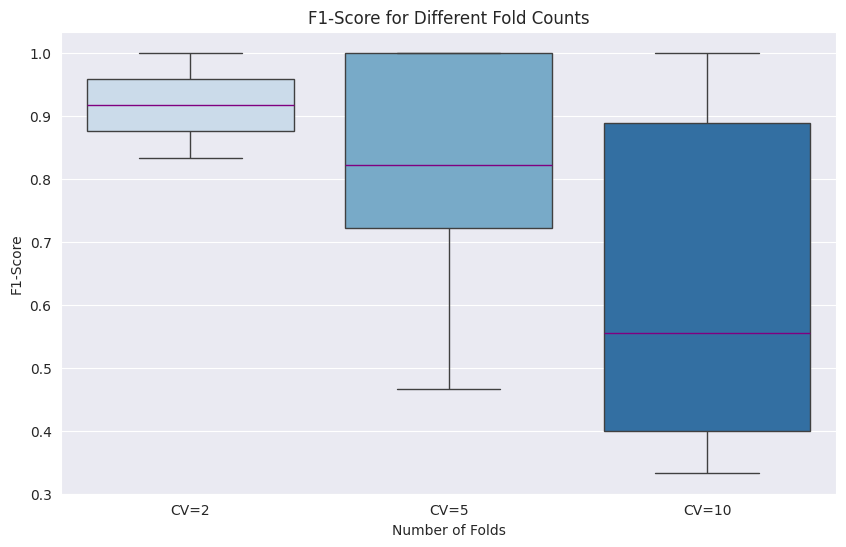

In [377]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
plt.xticks(range(len(folds)), [f"CV={fold}" for fold in folds])
plt.xlabel("Number of Folds")
plt.ylabel("F1-Score")
plt.title("F1-Score for Different Fold Counts")

## Zmiana parametru k

In [378]:
k = list(range(1, 16))

In [379]:
preprocessor =  Pipeline(
                    [
                        ("scaler", StandardScaler())
                    ])
scores = []
for i in k:
    model = KNeighborsClassifier(n_neighbors=i)
    pipeline = make_pipeline(preprocessor, model)
    cv = KFold(n_splits=5, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_iris, y_train_iris, cv=cv, scoring="f1_macro")
    scores.append(f1_scores)

Text(0.5, 1.0, 'F1-Score for Different K parameter values')

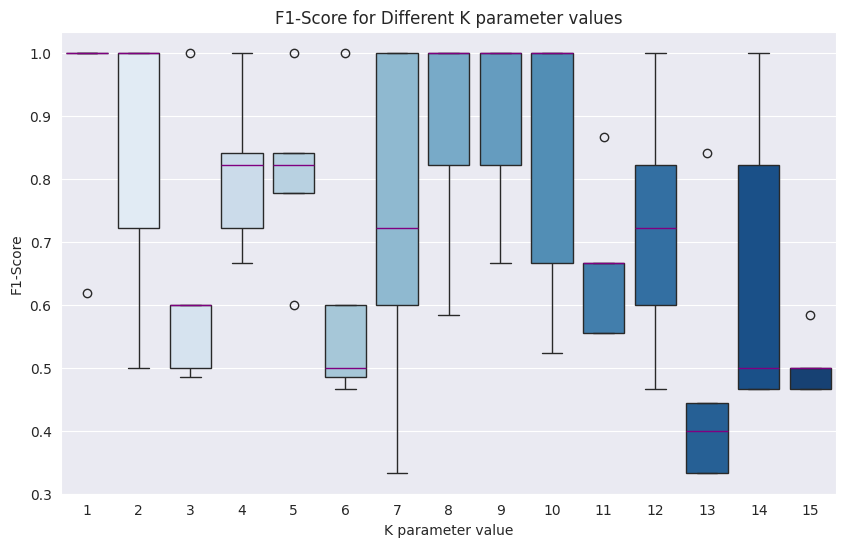

In [380]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
plt.xticks(range(len(k)), [i for i in k])
plt.xlabel("K parameter value")
plt.ylabel("F1-Score")
plt.title("F1-Score for Different K parameter values")

## Trzy sposoby głosowania

In [381]:
def inverse_distance_weights(distances):
    return 1 / (distances + 1e-10)

In [382]:
methods = ['uniform', 'distance', inverse_distance_weights]
preprocessor =  Pipeline([("scaler", StandardScaler())])

In [383]:
scores = []
for m in methods:
    model = KNeighborsClassifier(n_neighbors=5, weights=m)
    pipeline = make_pipeline(preprocessor, model)
    cv = KFold(n_splits=5, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_iris, y_train_iris, cv=cv, scoring="f1_macro")
    scores.append(f1_scores)

Text(0.5, 1.0, 'F1-Score for Different voting methods')

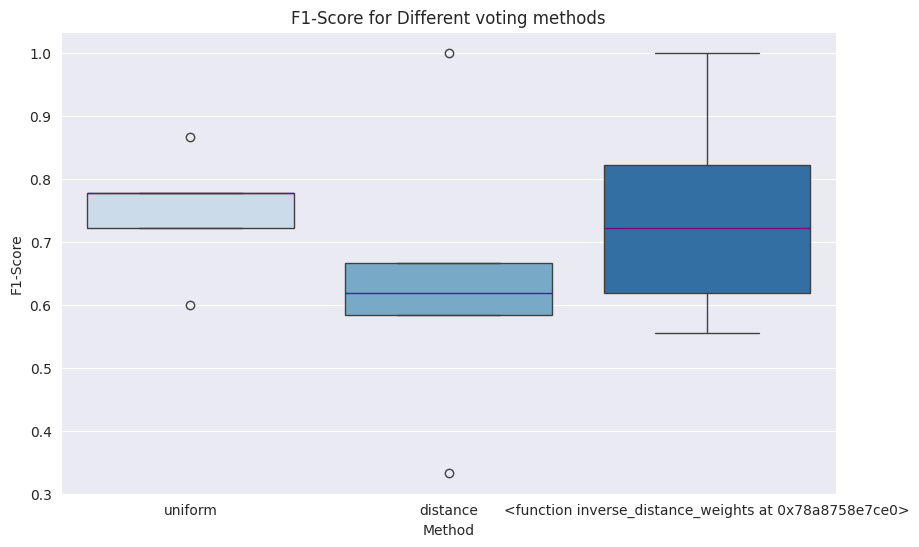

In [384]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
plt.xticks(range(len(methods)), [i for i in methods])
plt.xlabel("Method")
plt.ylabel("F1-Score")
plt.title("F1-Score for Different voting methods")

## Trzy miary odległości w przestrzeni danych

In [385]:
distances = ['euclidean', 'manhattan', 'cosine']
preprocessor =  Pipeline([("scaler", StandardScaler())])

In [386]:
scores = []
for d in distances:
    model = KNeighborsClassifier(n_neighbors=5, metric=d)
    pipeline = make_pipeline(preprocessor, model)
    folds = KFold(n_splits=5, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_iris, y_train_iris, cv=folds, scoring="f1_macro")
    scores.append(f1_scores)


Text(0.5, 1.0, 'F1-Score for Different distance metrics')

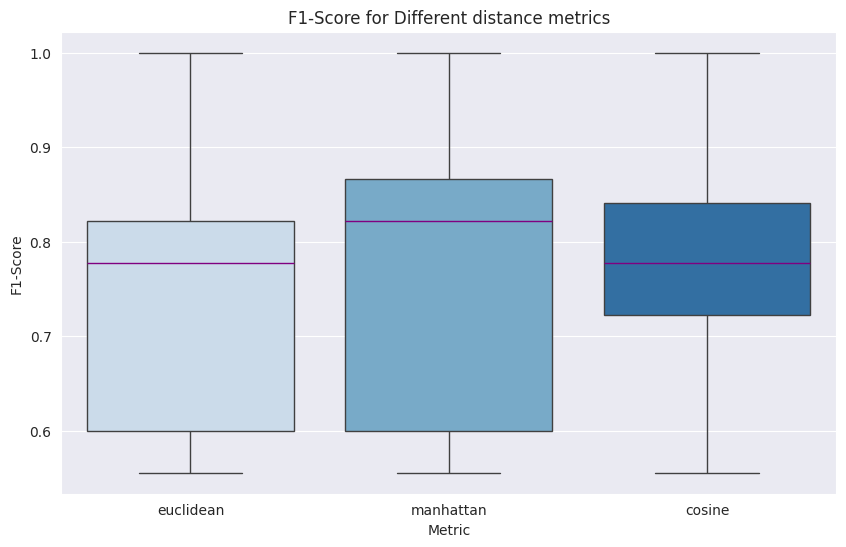

In [387]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
plt.xticks(range(len(distances)), [i for i in distances])
plt.xlabel("Metric")
plt.ylabel("F1-Score")
plt.title("F1-Score for Different distance metrics")

# Analiza skuteczności algorytmu K-nn na zbiorze WINE dla różnych parametrów
## Zmiana liczby foldów w walidacji krzyżowej

In [388]:
model = KNeighborsClassifier()
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
    ])
pipeline = make_pipeline(preprocessor, model)
folds = [2, 5, 10]

In [389]:
scores = []
for fold in folds:
    cv = KFold(n_splits=fold, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_wine, y_train_wine, cv=cv, scoring="f1_macro")
    scores.append(f1_scores)

Text(0.5, 1.0, 'F1-Score for Different Fold Counts')

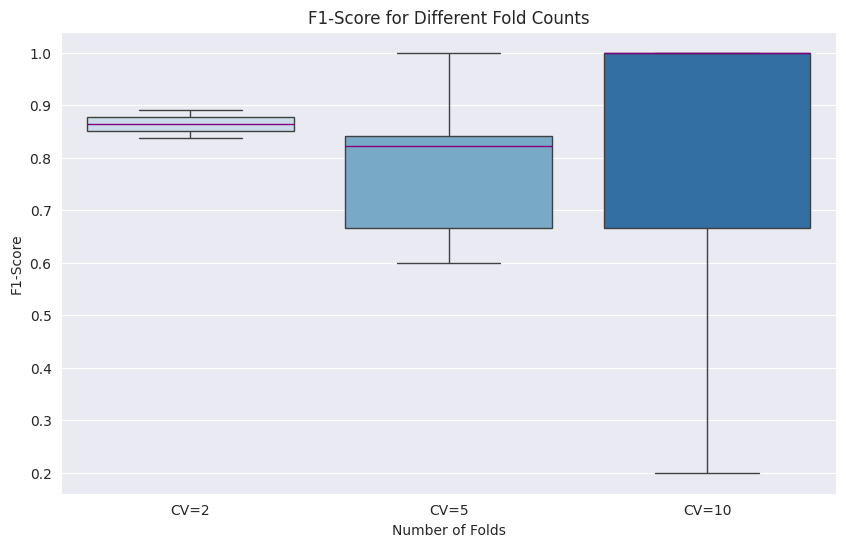

In [390]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
plt.xticks(range(len(folds)), [f"CV={fold}" for fold in folds])
plt.xlabel("Number of Folds")
plt.ylabel("F1-Score")
plt.title("F1-Score for Different Fold Counts")

## Zmiana parametru k

In [391]:
k = list(range(1, 16))
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
    ])

In [392]:
scores = []
for i in k:
    model = KNeighborsClassifier(n_neighbors=i)
    pipeline = make_pipeline(preprocessor, model)
    cv = KFold(n_splits=5, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_wine, y_train_wine, cv=cv, scoring="f1_macro")
    scores.append(f1_scores)

Text(0.5, 1.0, 'F1-Score for Different K parameter values')

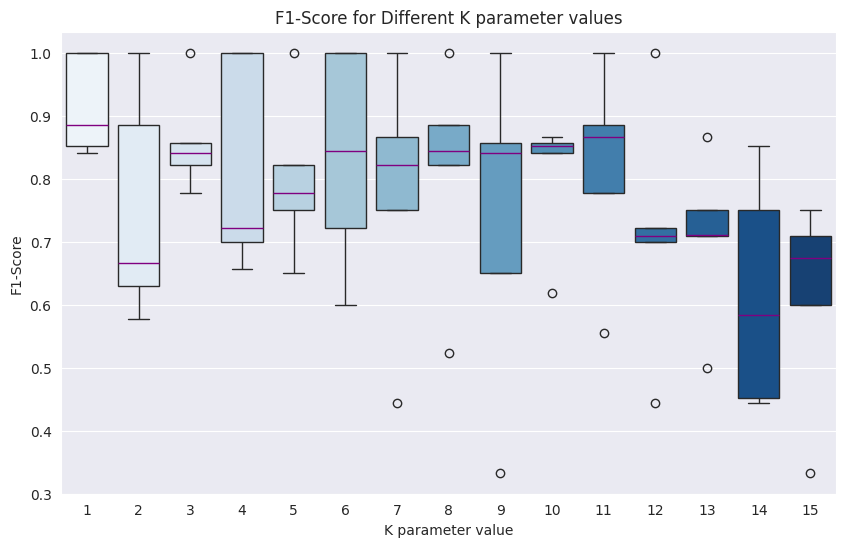

In [393]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
plt.xticks(range(len(k)), [i for i in k])
plt.xlabel("K parameter value")
plt.ylabel("F1-Score")
plt.title("F1-Score for Different K parameter values")

## Trzy sposoby głosowania

In [394]:
methods = ['uniform', 'distance', inverse_distance_weights]
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
    ])

In [395]:
scores = []
for m in methods:
    model = KNeighborsClassifier(n_neighbors=5, weights=m)
    pipeline = make_pipeline(preprocessor, model)
    cv = KFold(n_splits=5, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_wine, y_train_wine, cv=cv, scoring="f1_macro")
    scores.append(f1_scores)

Text(0.5, 1.0, 'F1-Score for Different voting methods')

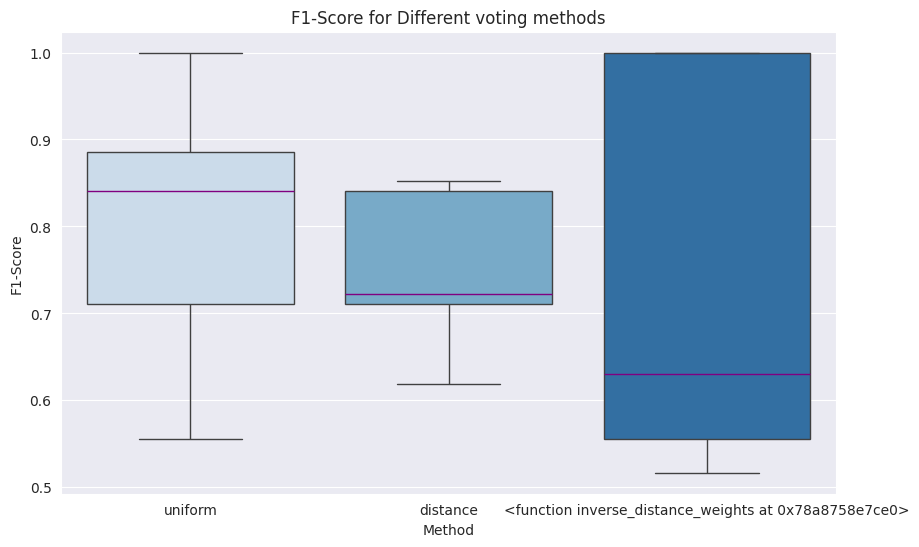

In [396]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
plt.xticks(range(len(methods)), [i for i in methods])
plt.xlabel("Method")
plt.ylabel("F1-Score")
plt.title("F1-Score for Different voting methods")

## Trzy miary odległości w przestrzeni danych

In [397]:
distances = ['euclidean', 'manhattan', 'cosine']
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
    ])

In [398]:
scores = []
for d in distances:
    model = KNeighborsClassifier(n_neighbors=5, metric=d)
    pipeline = make_pipeline(preprocessor, model)
    folds = KFold(n_splits=5, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_wine, y_train_wine, cv=folds, scoring="f1_macro")
    scores.append(f1_scores)

Text(0.5, 1.0, 'F1-Score for Different distance metrics')

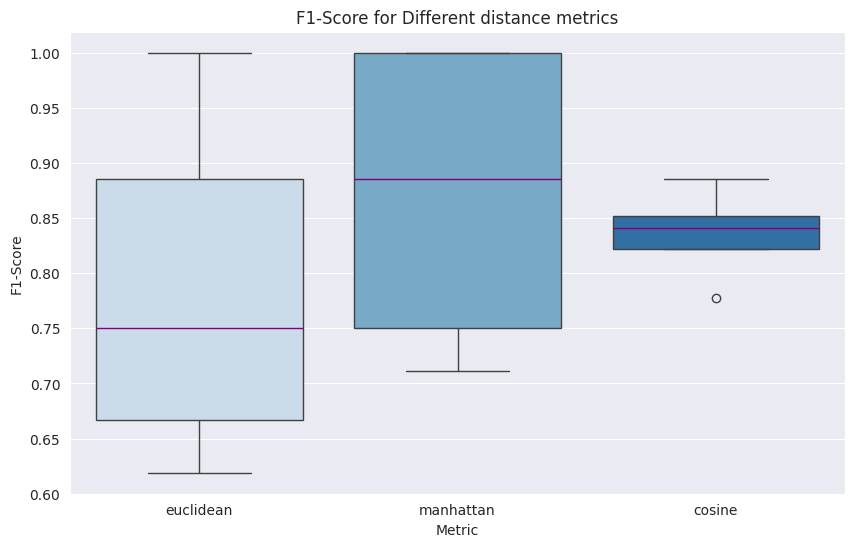

In [399]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
plt.xticks(range(len(distances)), [i for i in distances])
plt.xlabel("Metric")
plt.ylabel("F1-Score")
plt.title("F1-Score for Different distance metrics")

# Analiza skuteczności algorytmu K-nn na zbiorze Polish Companies Bancrupcy dla różnych parametrów
## Zmiana liczby foldów w walidacji krzyżowej

In [400]:
model = KNeighborsClassifier()
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
    ])
pipeline = make_pipeline(preprocessor, model)
folds = [2, 5, 10]

In [401]:
scores = []
for fold in folds:
    cv = KFold(n_splits=fold, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_companies, y_train_companies, cv=cv, scoring="f1_macro")
    scores.append(f1_scores)

Text(0.5, 1.0, 'F1-Score for Different Fold Counts')

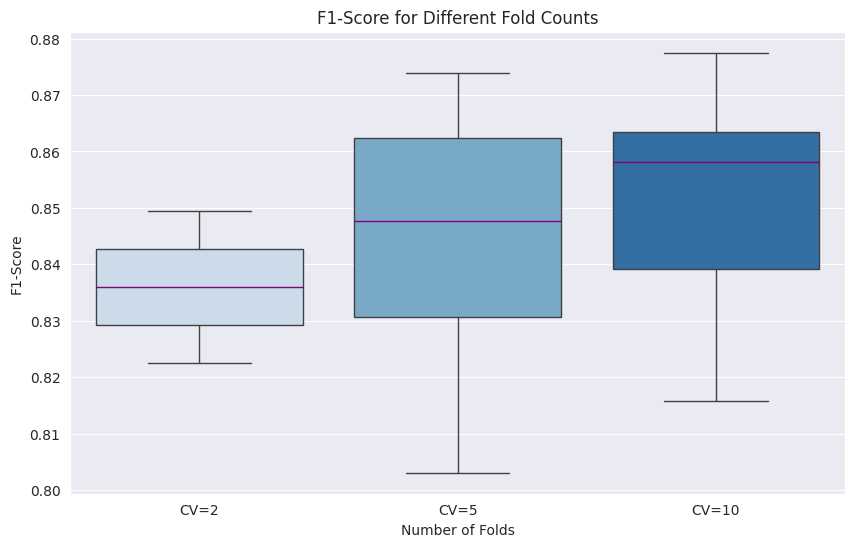

In [402]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
plt.xticks(range(len(folds)), [f"CV={fold}" for fold in folds])
plt.xlabel("Number of Folds")
plt.ylabel("F1-Score")
plt.title("F1-Score for Different Fold Counts")

## Zmiana parametru k

In [403]:
k = list(range(1, 16))
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
    ])

In [404]:
scores = []
for i in k:
    model = KNeighborsClassifier(n_neighbors=i)
    pipeline = make_pipeline(preprocessor, model)
    cv = KFold(n_splits=5, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_companies, y_train_companies, cv=cv, scoring="f1_macro")
    scores.append(f1_scores)

Text(0.5, 1.0, 'F1-Score for Different K parameter values')

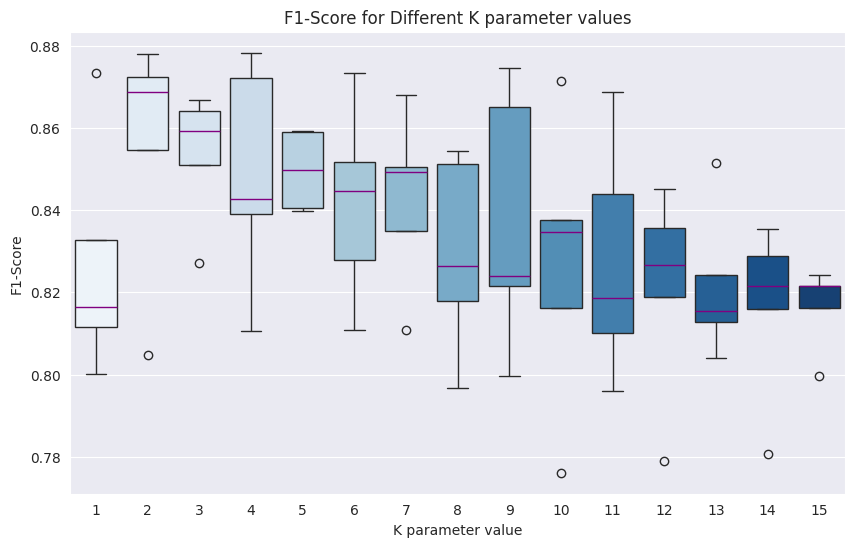

In [405]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
plt.xticks(range(len(k)), [i for i in k])
plt.xlabel("K parameter value")
plt.ylabel("F1-Score")
plt.title("F1-Score for Different K parameter values")

In [406]:
methods = ['uniform', 'distance', inverse_distance_weights]
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
    ])

In [407]:
scores = []
for m in methods:
    model = KNeighborsClassifier(n_neighbors=5, weights=m)
    pipeline = make_pipeline(preprocessor, model)
    cv = KFold(n_splits=5, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_companies, y_train_companies, cv=cv, scoring="f1_macro")
    scores.append(f1_scores)

Text(0.5, 1.0, 'F1-Score for Different voting methods')

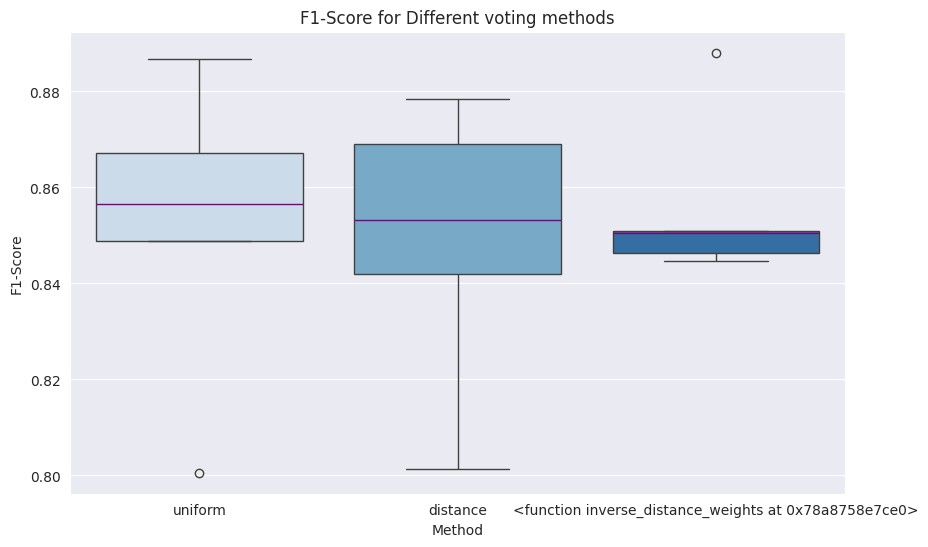

In [408]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
plt.xticks(range(len(methods)), [i for i in methods])
plt.xlabel("Method")
plt.ylabel("F1-Score")
plt.title("F1-Score for Different voting methods")

## Trzy mialy odległości w przestrzeni danych

In [281]:
distances = ['euclidean', 'manhattan', 'cosine']
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
    ])

In [409]:
scores = []
for d in distances:
    model = KNeighborsClassifier(n_neighbors=5, metric=d)
    pipeline = make_pipeline(preprocessor, model)
    folds = KFold(n_splits=5, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_companies, y_train_companies, cv=folds, scoring="f1_macro")
    scores.append(f1_scores)

Text(0.5, 1.0, 'F1-Score for Different distance metrics')

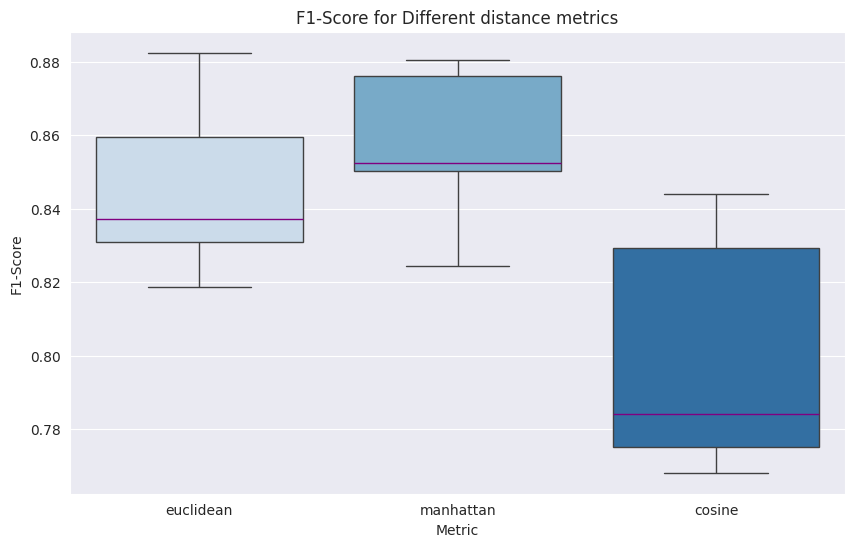

In [410]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=scores, palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
plt.xticks(range(len(distances)), [i for i in distances])
plt.xlabel("Metric")
plt.ylabel("F1-Score")
plt.title("F1-Score for Different distance metrics")

# Różnica między walidacją krzyżową a walidacją krzyżową stratyfikowaną

## Dataset PCB

In [411]:
model = KNeighborsClassifier()
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
    ])
pipeline = make_pipeline(preprocessor, model)
folds = [2, 5, 10]

In [412]:
scores_kfold = []
for fold in folds:
    cv = KFold(n_splits=fold, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_companies, y_train_companies, cv=cv, scoring="f1_macro")
    scores_kfold.append(f1_scores)

In [413]:
model = KNeighborsClassifier()
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
    ])
pipeline = make_pipeline(preprocessor, model)

In [414]:
scores_strat_kfold = []
for fold in folds:
    cv = StratifiedKFold(n_splits=fold, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_companies, y_train_companies, cv=cv, scoring="f1_macro")
    scores_strat_kfold.append(f1_scores)

Text(0.5, 1.0, 'F1-Score for Different Fold Counts (Stratified KFold)')

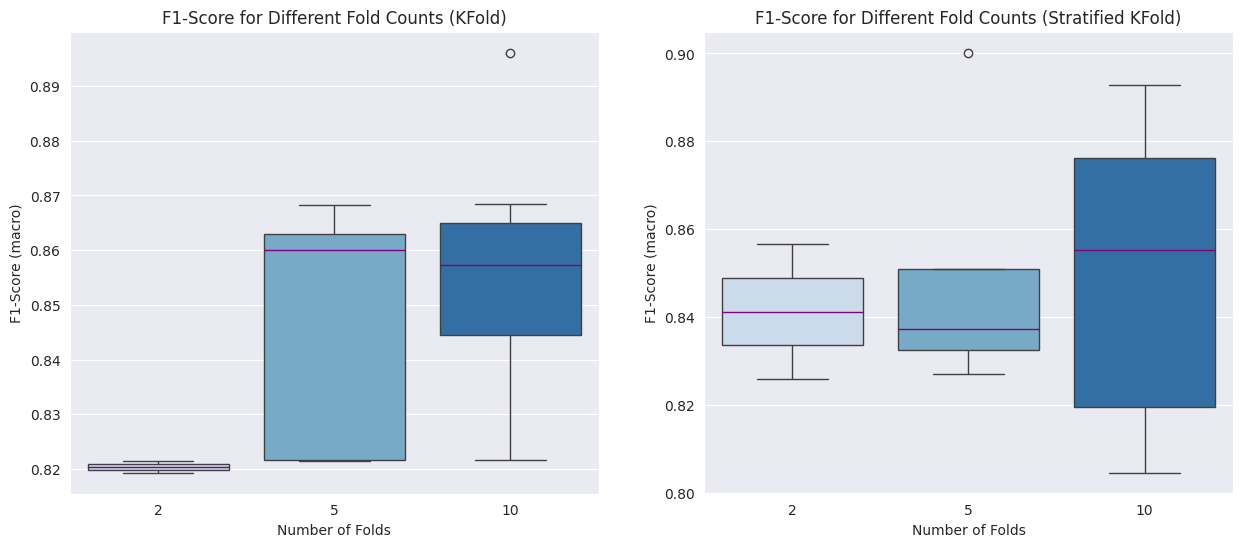

In [415]:
_, ax = plt.subplots(1, 2, figsize=(15, 6))
ax = ax.flatten()
sns.boxplot(data=scores_kfold, palette="Blues", ax=ax[0], medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
ax[0].set_xticks(range(len(folds)), [fold for fold in folds])
ax[0].set_xlabel("Number of Folds")
ax[0].set_ylabel("F1-Score (macro)")
ax[0].set_title("F1-Score for Different Fold Counts (KFold)")

sns.boxplot(data=scores_strat_kfold, palette="Blues", ax=ax[1], medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
ax[1].set_xticks(range(len(folds)), [fold for fold in folds])
ax[1].set_xlabel("Number of Folds")
ax[1].set_ylabel("F1-Score (macro)")
ax[1].set_title("F1-Score for Different Fold Counts (Stratified KFold)")

## Dataset WINE

In [417]:
model = KNeighborsClassifier()
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
    ])
pipeline = make_pipeline(preprocessor, model)
folds = [2, 5, 10]

In [418]:
scores_kfold = []
for fold in folds:
    cv = KFold(n_splits=fold, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_wine, y_train_wine, cv=cv, scoring="f1_macro")
    scores_kfold.append(f1_scores)

In [419]:
model = KNeighborsClassifier()
preprocessor = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
    ])
pipeline = make_pipeline(preprocessor, model)

In [421]:
scores_strat_kfold = []
for fold in folds:
    cv = StratifiedKFold(n_splits=fold, shuffle=True)
    f1_scores = cross_val_score(pipeline, X_train_wine, y_train_wine, cv=cv, scoring="f1_macro")
    scores_strat_kfold.append(f1_scores)

/home/mindflayer77/miniconda3/envs/um-lab/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Text(0.5, 1.0, 'F1-Score for Different Fold Counts (Stratified KFold)')

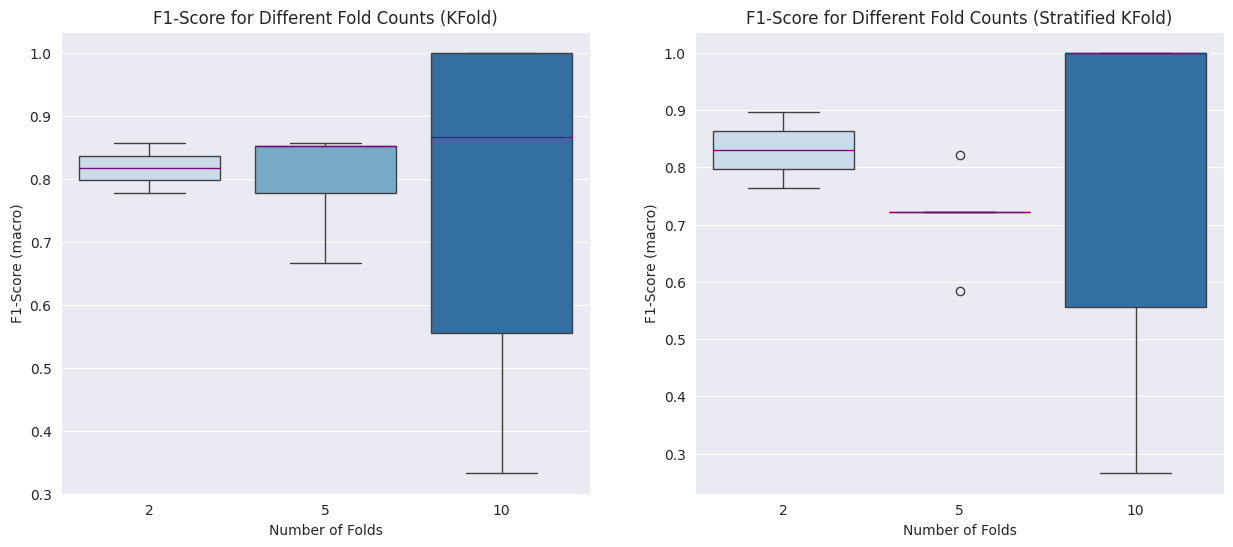

In [422]:
_, ax = plt.subplots(1, 2, figsize=(15, 6))
ax = ax.flatten()
sns.boxplot(data=scores_kfold, palette="Blues", ax=ax[0], medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
ax[0].set_xticks(range(len(folds)), [fold for fold in folds])
ax[0].set_xlabel("Number of Folds")
ax[0].set_ylabel("F1-Score (macro)")
ax[0].set_title("F1-Score for Different Fold Counts (KFold)")

sns.boxplot(data=scores_strat_kfold, palette="Blues", ax=ax[1], medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
ax[1].set_xticks(range(len(folds)), [fold for fold in folds])
ax[1].set_xlabel("Number of Folds")
ax[1].set_ylabel("F1-Score (macro)")
ax[1].set_title("F1-Score for Different Fold Counts (Stratified KFold)")

# Znalezienie najlepszej kombinacji parametrów

In [416]:
param_grid = {
    'knn__n_neighbors': list(range(1, 16)),
    'knn__weights': ['uniform', 'distance', inverse_distance_weights],
    'knn__metric': ['euclidean', 'manhattan', 'cosine'],
}
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95)),
        ("knn", KNeighborsClassifier())
    ])

folds = [2, 5, 10]

In [247]:
results = {}
for fold in folds:
    print(f"\nRunning GridSearch with {fold}-fold CV")
    cv = KFold(n_splits=fold, shuffle=True)
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=cv,
        scoring='f1_macro',
        verbose=1
    )

    grid_search.fit(X_train_companies, y_train_companies)

    results[fold] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_results': grid_search.cv_results_
    }


Running GridSearch with 2-fold CV
Fitting 2 folds for each of 135 candidates, totalling 270 fits

Running GridSearch with 5-fold CV
Fitting 5 folds for each of 135 candidates, totalling 675 fits

Running GridSearch with 10-fold CV
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


In [291]:
for fold, result in results.items():
    print(f"{fold}-fold CV | Best params: {result['best_params']} | Score: {result['best_score']:.4f}")

2-fold CV | Best params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'} | Score: 0.8576
5-fold CV | Best params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'} | Score: 0.8612
10-fold CV | Best params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 4, 'knn__weights': 'distance'} | Score: 0.8662


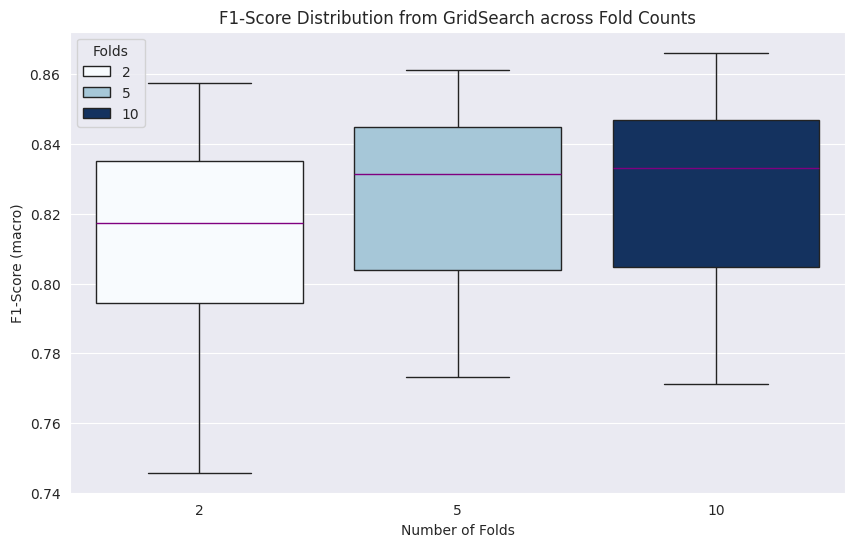

In [294]:
plot_data = []
for fold, result in results.items():
    scores = result['cv_results']['mean_test_score']
    for score in scores:
        plot_data.append({'Folds': fold, 'F1-Score': score})

df_plot = pd.DataFrame(plot_data)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Folds', y='F1-Score', data=df_plot, hue="Folds", palette="Blues", medianprops={'color': 'purple', 'ls': '-', 'lw': 1})
plt.xlabel("Number of Folds")
plt.ylabel("F1-Score (macro)")
plt.title("F1-Score Distribution from GridSearch across Fold Counts")
plt.show()

# Ewaluacja modelu na podstawie najlepszych parametrów

In [320]:
model = KNeighborsClassifier(n_neighbors=4, weights='distance', metric='manhattan')
model.fit(X_train_companies_pca, y_train_companies)

KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')


Test results:

Accuracy: 0.9766015579583769

Classification Report for Companies dataset:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     32738
           1       0.94      0.55      0.70      1666

    accuracy                           0.98     34404
   macro avg       0.96      0.78      0.84     34404
weighted avg       0.98      0.98      0.97     34404



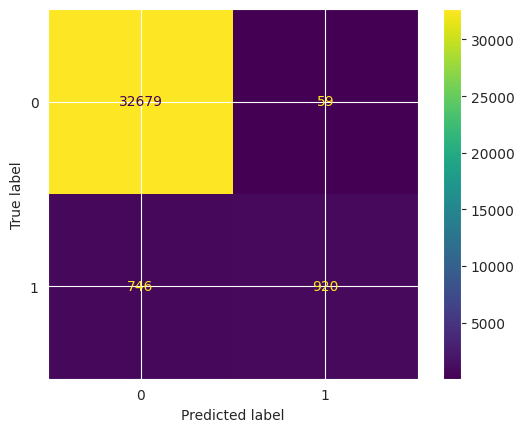

In [321]:
predictions = model.predict(X_test_companies_pca)
result = accuracy_score(y_test_companies, predictions)
print("\nTest results:")
print("\nAccuracy:", result)
print("\nClassification Report for Companies dataset:")
print(classification_report(y_test_companies, predictions))

cm = confusion_matrix(y_test_companies, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()